In [30]:
# Import delle librerie necessarie
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod.families import Poisson, Gamma, Binomial
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Configurazione visualizzazioni
plt.rcParams['figure.figsize'] = (10, 6)
sns.set_style("whitegrid")

# 1. Regressione di Poisson - Analisi incidenti stradali

![Esempio modello binomiale](images/poisson_slide.png)

### Perché Poisson?
- I dati rappresentano **conteggi** (numero di incidenti)
- I valori sono **interi non negativi** (0, 1, 2, ...)
- La varianza aumenta con la media
- Eventi rari in un intervallo di tempo/spazio

In [31]:
#importazione del dataset
df_poisson = pd.read_csv('data/incidenti_stradali.csv')
df_poisson.head()

,n_incidenti,velocita_media,traffico_intenso,meteo_pioggia,meteo_nebbia
0,0,52.472407,1,0,0
1,2,87.042858,0,0,1
2,0,73.919637,0,0,0
3,1,65.919509,1,1,0
4,0,39.361118,1,0,0


In [32]:
print(f"\nStatistiche descrittive:")
print(df_poisson['n_incidenti'].describe())



Statistiche descrittive:
count    200.000000
mean       1.335000
std        1.443326
min        0.000000
25%        0.000000
50%        1.000000
75%        2.000000
max        8.000000
Name: n_incidenti, dtype: float64


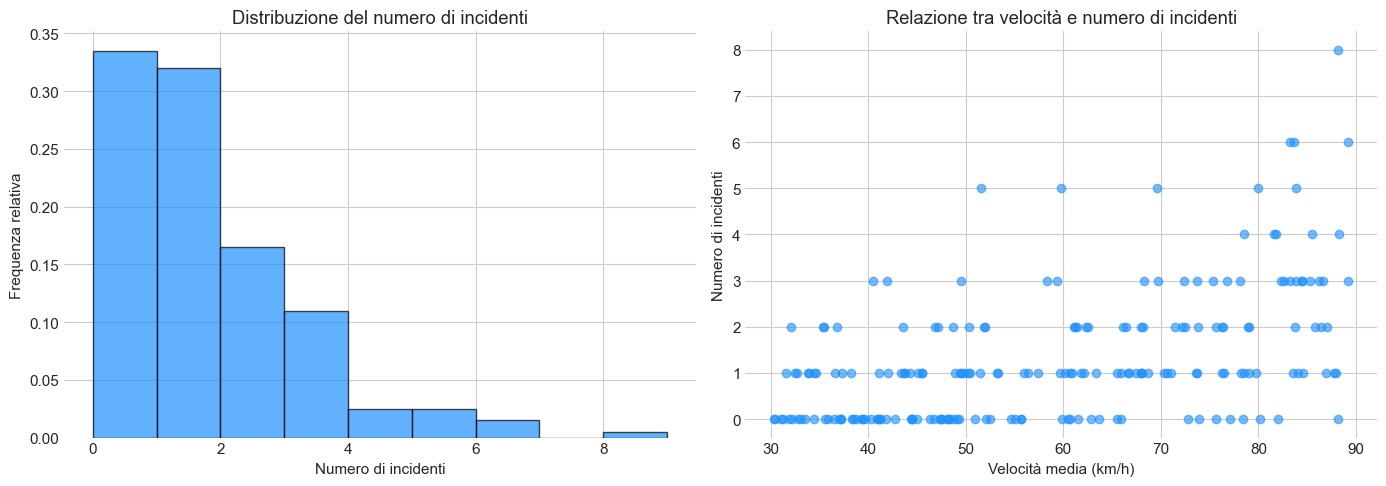

In [33]:
# Visualizzazione distribuzione
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Istogramma numero incidenti
axes[0].hist(df_poisson['n_incidenti'], bins=range(0, max(df_poisson.n_incidenti)+2), 
             density=True, alpha=0.7, color='dodgerblue', edgecolor='black')
axes[0].set_xlabel('Numero di incidenti')
axes[0].set_ylabel('Frequenza relativa')
axes[0].set_title('Distribuzione del numero di incidenti')

# Relazione con velocità media
axes[1].scatter(df_poisson['velocita_media'], df_poisson['n_incidenti'], alpha=0.6, color='dodgerblue')
axes[1].set_xlabel('Velocità media (km/h)')
axes[1].set_ylabel('Numero di incidenti')
axes[1].set_title('Relazione tra velocità e numero di incidenti')

plt.tight_layout()
plt.show()

In [34]:
# Preparazione variabili per il modello
X = df_poisson[['velocita_media', 'traffico_intenso', 'meteo_pioggia', 'meteo_nebbia']]
X = sm.add_constant(X)
y = df_poisson['n_incidenti']

# Modello di Poisson
model_poisson = GLM(y, X, family=Poisson())
results_poisson = model_poisson.fit()
print(results_poisson.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:            n_incidenti   No. Observations:                  200
Model:                            GLM   Df Residuals:                      195
Model Family:                 Poisson   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -265.93
Date:                Tue, 01 Jul 2025   Deviance:                       203.15
Time:                        15:44:48   Pearson chi2:                     178.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.4310
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -2.1316      0.284  

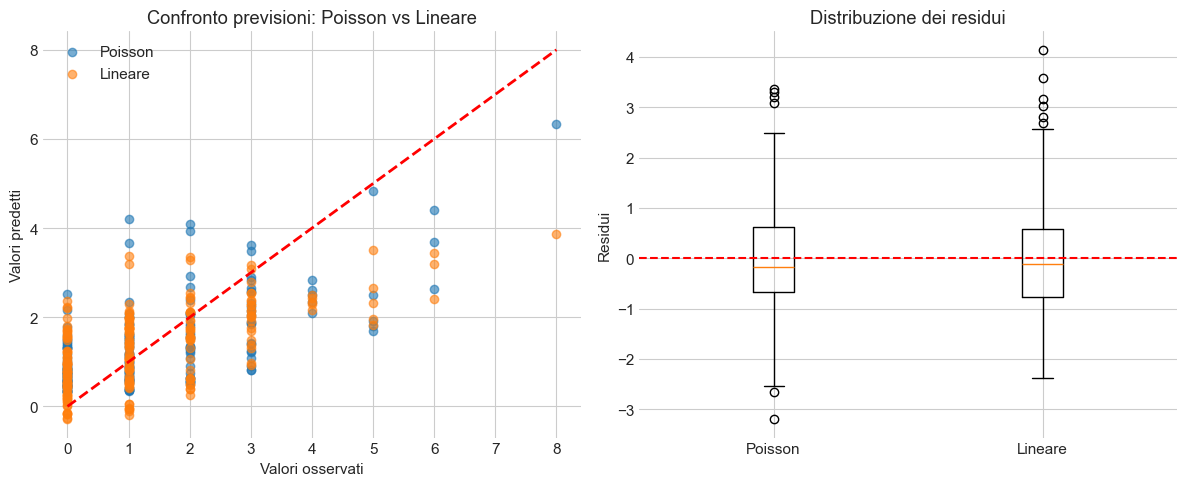

R² Poisson (pseudo): 0.357
R² Lineare: 0.374
AIC Poisson: 541.9
AIC Lineare: 629.5


In [35]:
# Confronto con regressione lineare
model_linear = sm.OLS(y, X)
results_linear = model_linear.fit()

# Previsioni
pred_poisson = results_poisson.predict(X)
pred_linear = results_linear.predict(X)

# Visualizzazione confronto
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y, pred_poisson, alpha=0.6, label='Poisson')
plt.scatter(y, pred_linear, alpha=0.6, label='Lineare')
plt.plot([0, max(y)], [0, max(y)], 'r--', lw=2)
plt.xlabel('Valori osservati')
plt.ylabel('Valori predetti')
plt.title('Confronto previsioni: Poisson vs Lineare')
plt.legend()

plt.subplot(1, 2, 2)
residuals_poisson = y - pred_poisson
residuals_linear = y - pred_linear
plt.boxplot([residuals_poisson, residuals_linear], labels=['Poisson', 'Lineare'])
plt.ylabel('Residui')
plt.title('Distribuzione dei residui')
plt.axhline(y=0, color='r', linestyle='--')

plt.tight_layout()
plt.show()

# Metriche di valutazione
print(f"R² Poisson (pseudo): {1 - results_poisson.deviance / results_poisson.null_deviance:.3f}")
print(f"R² Lineare: {results_linear.rsquared:.3f}")
print(f"AIC Poisson: {results_poisson.aic:.1f}")
print(f"AIC Lineare: {results_linear.aic:.1f}")


### Osservazioni sul modello di Poisson:
- Il modello di Poisson è più appropriato perché garantisce previsioni non negative
- La regressione lineare può produrre valori negativi (non sensati per conteggi)
- I coefficienti hanno interpretazione moltiplicativa (exp(β))

# 2. Regressione Gamma - Analisi costi assicurativi

![Esempio modello gamma](images/gamma_slide.png)

### Perché Gamma?
- I dati sono **continui e positivi** (costi > 0)
- Distribuzione **asimmetrica** con coda destra
- La varianza aumenta con la media
- Tipico di dati finanziari, tempi di attesa, costi

In [36]:
df_gamma = pd.read_csv('data/costi_assicurativi.csv')
df_gamma.head()

,costo_sinistro,eta_guidatore,anni_esperienza,veicolo_berlina,veicolo_suv,storico_incidenti
0,3363.264757,37.476086,16.935705,0,1,0
1,2983.896358,67.437144,44.892602,0,1,1
2,2332.864782,56.063685,36.724140,0,0,0
3,2188.704923,49.130241,33.699438,0,1,1
4,2248.365714,26.112969,8.755251,0,0,0


In [37]:
print(f"\nStatistiche descrittive costi:")
print(df_gamma['costo_sinistro'].describe())


Statistiche descrittive costi:
count      250.000000
mean      2958.234733
std       2445.625802
min         84.518955
25%       1316.190502
50%       2349.774227
75%       3764.468894
max      17388.698247
Name: costo_sinistro, dtype: float64


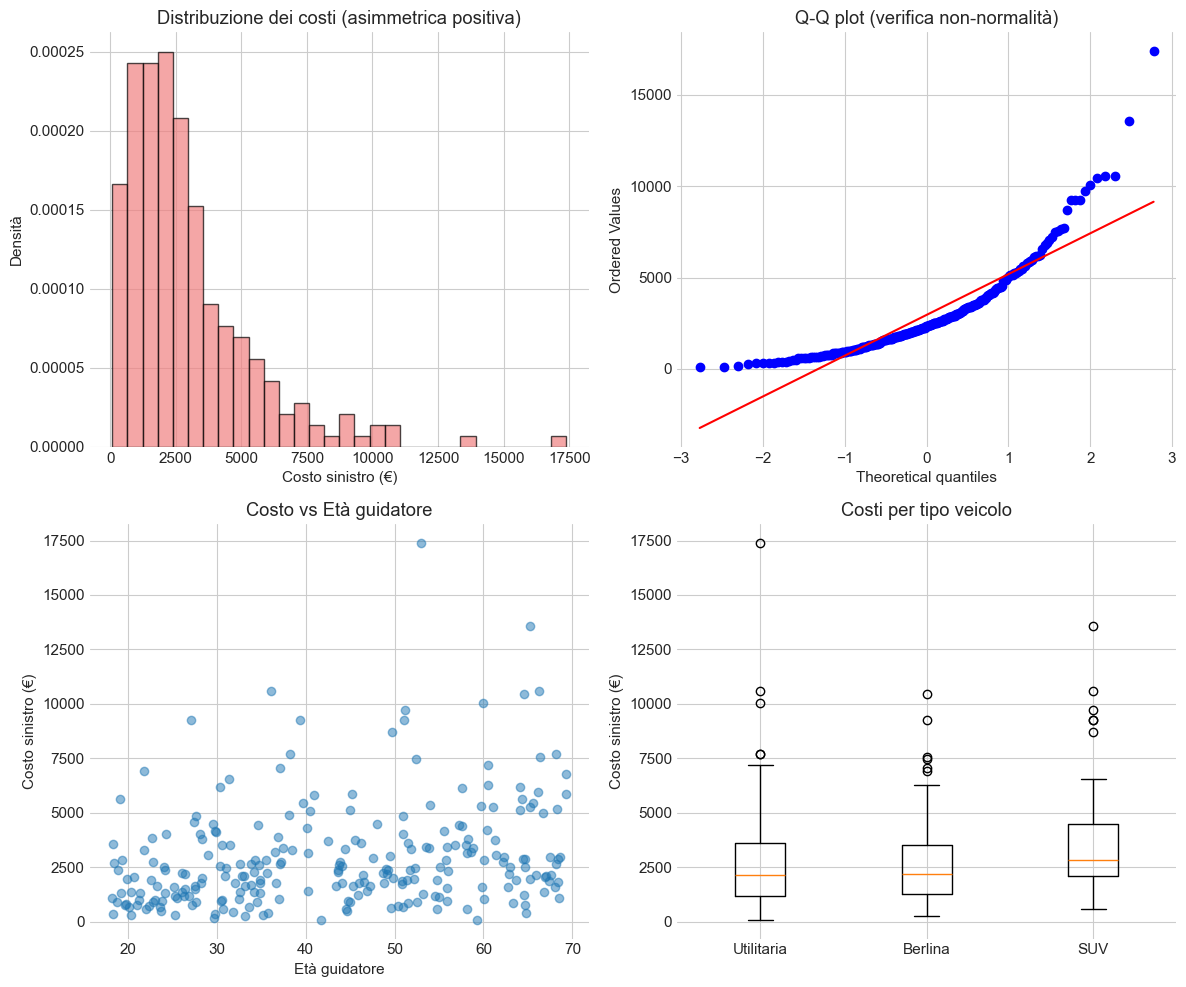

In [39]:
# Visualizzazione distribuzione
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Istogramma costi
axes[0, 0].hist(df_gamma['costo_sinistro'], bins=30, density=True, 
                alpha=0.7, color='lightcoral', edgecolor='black')
axes[0, 0].set_xlabel('Costo sinistro (€)')
axes[0, 0].set_ylabel('Densità')
axes[0, 0].set_title('Distribuzione dei costi (asimmetrica positiva)')

# Q-Q plot per verificare non-normalità
stats.probplot(df_gamma['costo_sinistro'], dist="norm", plot=axes[0, 1])
axes[0, 1].set_title('Q-Q plot (verifica non-normalità)')

# Relazione con età
axes[1, 0].scatter(df_gamma['eta_guidatore'], df_gamma['costo_sinistro'], alpha=0.5)
axes[1, 0].set_xlabel('Età guidatore')
axes[1, 0].set_ylabel('Costo sinistro (€)')
axes[1, 0].set_title('Costo vs Età guidatore')

# Box plot per tipo veicolo
# Box plot per tipo veicolo (usando le dummy già presenti)
axes[1, 1].boxplot([
    df_gamma.loc[(df_gamma['veicolo_berlina'] == 0) & (df_gamma['veicolo_suv'] == 0), 'costo_sinistro'],  # Utilitaria
    df_gamma.loc[df_gamma['veicolo_berlina'] == 1, 'costo_sinistro'],  # Berlina
    df_gamma.loc[df_gamma['veicolo_suv'] == 1, 'costo_sinistro']       # SUV
], labels=['Utilitaria', 'Berlina', 'SUV'])
axes[1, 1].set_ylabel('Costo sinistro (€)')
axes[1, 1].set_title('Costi per tipo veicolo')

plt.tight_layout()
plt.show()


In [ ]:
# Preparazione variabili
X_gamma = df_gamma[['eta_guidatore', 'anni_esperienza', 'veicolo_berlina', 
                    'veicolo_suv', 'storico_incidenti']]
X_gamma = sm.add_constant(X_gamma)
y_gamma = df_gamma['costo_sinistro']

# Modello Gamma con link log
model_gamma = GLM(y_gamma, X_gamma, family=Gamma(link=sm.families.links.Log()))
results_gamma = model_gamma.fit()
print(results_gamma.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:         costo_sinistro   No. Observations:                  250
Model:                            GLM   Df Residuals:                      244
Model Family:                   Gamma   Df Model:                            5
Link Function:                    Log   Scale:                         0.46502
Method:                          IRLS   Log-Likelihood:                -2199.3
Date:                Wed, 18 Jun 2025   Deviance:                       127.83
Time:                        16:58:53   Pearson chi2:                     113.
No. Iterations:                    15   Pseudo R-squ. (CS):             0.2404
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 7.2015      0.29

### Osservazioni sul modello Gamma:
- Il modello Gamma cattura meglio l'eteroschedasticità dei dati
- Garantisce previsioni sempre positive
- Più appropriato per dati finanziari con asimmetria positiva

# 3. Regressione Binomiale - Analisi tassi di conversione

![Esempio modello binomiale](images/binomial_slide.png)

## Perché Binomiale?
- I dati rappresentano **proporzioni** (successi su n tentativi)
- Valori limitati tra 0 e 1
- Numero fisso di prove per ogni osservazione
- Varianza dipende dalla proporzione


In [71]:
import statsmodels.formula.api as smf

df_binomiale = pd.read_csv('data/marketing_performance.csv')
df_binomiale.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       50 non-null     float64
 1   succ    50 non-null     int64  
 2   fail    50 non-null     int64  
dtypes: float64(1), int64(2)
memory usage: 1.3 KB


In [72]:
df_binomiale.head(10)

,x,succ,fail
0,0.000000,1,3
1,0.081633,1,3
2,0.163265,1,1
3,0.244898,0,3
4,0.326531,2,3
5,0.408163,1,4
6,0.489796,0,5
7,0.571429,2,2
8,0.653061,0,4
9,0.734694,1,1


In [ ]:
succ = df_binomiale['succ']
fail = df_binomiale['fail']
x = df_binomiale['x']
n = succ + fail

# the binomial regression itself:
binom = sm.families.Binomial()
binom_model = smf.glm('succ/succ+fail ~ x', df_binomiale, family=binom).fit()
binom_model.summary2()



<class 'statsmodels.iolib.summary2.Summary'>
"""
              Results: Generalized linear model
==============================================================
Model:              GLM              AIC:            122.3886 
Link Function:      Logit            BIC:            -132.6900
Dependent Variable: ['succ', 'fail'] Log-Likelihood: -59.194  
Date:               2025-07-01 16:51 LL-Null:        -83.840  
No. Observations:   50               Deviance:       55.087   
Df Model:           1                Pearson chi2:   45.0     
Df Residuals:       48               Scale:          1.0000   
Method:             IRLS                                      
---------------------------------------------------------------
            Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
---------------------------------------------------------------
Intercept  -1.9309    0.3546  -5.4461  0.0000  -2.6258  -1.2360
x           0.9592    0.1542   6.2199  0.0000   0.6570   1.2615
==============================================================

"""

Text(0.5, 1.0, 'Binomial regression (simulation)')

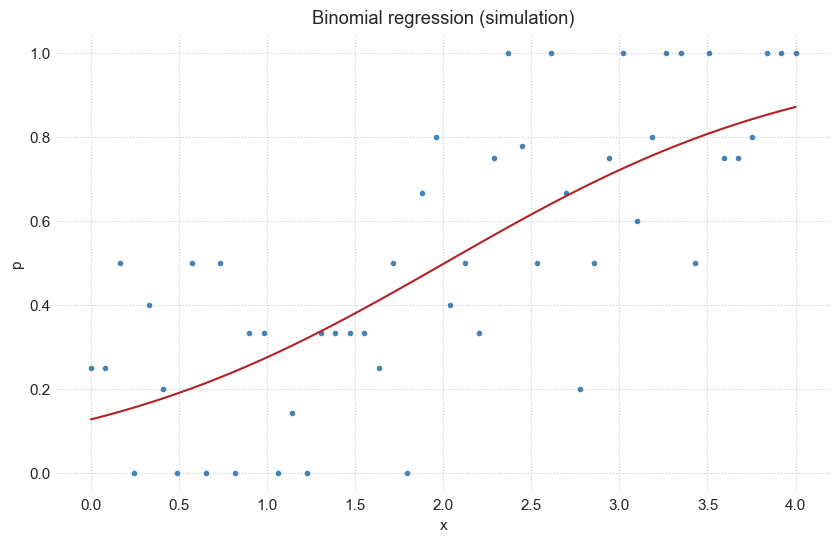

In [68]:
# visualise the result:
plt.plot(x, succ/n, '.', c='steelblue')
plt.plot(x, binom_model.predict(), c='firebrick')
plt.grid(linestyle=':')
plt.xlabel('x')
plt.ylabel('p')
plt.title('Binomial regression (simulation)')